In [378]:
import numpy as np
import pandas as pd
import sys 
sys.path.insert(0, '/home/toque/work/forecast/utils/')
import utils
import utils_date

import itertools
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa import arima_model

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import seaborn
seaborn.set_style('whitegrid')

from tqdm import tqdm
import ast
import os

In [2]:
def create_Xy_basic(start, end, obs, fea, index='Datetime'):
    """
            extract values from dataframe obs to y variable 
            and values of dataframe fea to X variable
    """
    
    date_list = utils_date.get_list_common_date(start, end, obs, [fea])
    
    y = obs.set_index(index).loc[date_list].values
    X = fea.set_index(index).loc[date_list].values
    mask = (X!=0).sum(axis=0)!=0
    
    X = X[:,mask]
    y_name_list = obs.set_index(index).columns.values
    X_name_list = fea.set_index(index).columns.values[mask]
    
    return y, X, y_name_list, X_name_list

# root mean squared error or rmse
def measure_rmse(obs, pred):
    return sqrt(mean_squared_error(obs, pred))

In [52]:
name_list = pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')['stop_name'].values
dict_id_name = dict([(i,j) for i,j in pd.read_csv('/home/toque/data2/montreal/stm/data/station_info.csv')[['stop_id','stop_name']].values])

In [3]:
obs_path = ['/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree_aggdaily.csv']
fea_path = ['/home/toque/data2/date/2013-01-01-2019-01-01_new.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_start_event_stopid_aggdaily.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_end_event_stopid_aggdaily.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_period_event_stopid_aggdaily.csv',
           ]

obs = utils.read_csv_list(obs_path)
fea = utils.read_csv_list(fea_path)

In [4]:
features_others = ['2-end_event', '3-end_event', '4-end_event', '5-end_event',
                       '6-end_event', '8-end_event', '9-end_event', '10-end_event',
                       '11-end_event', '12-end_event', '13-end_event', '14-end_event',
                       '15-end_event', '16-end_event', '23-end_event', '24-end_event',
                       '30-end_event', '31-end_event', '32-end_event', '34-end_event',
                       '35-end_event', '40-end_event', '43-end_event', '45-end_event',
                       '47-end_event', '61-end_event', '68-end_event', '1-start_event',
                       '2-start_event', '3-start_event', '4-start_event', '5-start_event',
                       '6-start_event', '8-start_event', '9-start_event', '10-start_event',
                       '11-start_event', '12-start_event', '13-start_event',
                       '14-start_event', '15-start_event', '16-start_event',
                       '23-start_event', '24-start_event', '29-start_event',
                       '30-start_event', '31-start_event', '32-start_event',
                       '34-start_event', '35-start_event', '40-start_event',
                       '43-start_event', '45-start_event', '47-start_event',
                       '61-start_event', '68-start_event', '16-period_event',
                       '15-period_event', '13-period_event', '12-period_event',
                       '45-period_event', '24-period_event', '43-period_event',
                       '9-period_event', '31-period_event', '10-period_event',
                       '47-period_event', '8-period_event', '11-period_event',
                       '30-period_event', '4-period_event', '61-period_event',
                       '14-period_event', '68-period_event', '23-period_event',
                       '5-period_event', '6-period_event', '34-period_event',
                       '32-period_event', '40-period_event', '35-period_event',
                       '3-period_event', '2-period_event']

features_todummy = ['Day_en', 'Mois']

features_nottodummy = ['24DEC', '31DEC', 'day_off_quebec', 'renov_beaubien', 
                       'vac_udem1', 'vac_udem2', 'vac_noel_quebec', 'Year',]

time_series = ['11', '32', '34', '15', '44', '65', '31', '33', '35', '47', '13',
       '14', '1', '9', '5', '18', '36', '24', '68', '43', '8', '64', '10',
       '55', '3', '49', '51', '2', '19', '56', '7', '6', '4', '48', '66',
       '25', '23', '28', '39', '54', '60', '27', '20', '46', '12', '21',
       '62', '52', '41', '50', '30', '16', '37', '40', '26', '67', '57',
       '61', '42', '45', '38', '29', '58', '63', '22', '59', '53', '17']

fea = utils.df_todummy_df(fea, features_todummy, features_nottodummy)
obs = obs.set_index('Datetime')[time_series].reset_index()

In [103]:
fea.columns

Index(['Datetime', '24DEC', '31DEC', 'day_off_quebec', 'renov_beaubien',
       'vac_udem1', 'vac_udem2', 'vac_noel_quebec', 'Year', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'April', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October'],
      dtype='object')

# Daily number of passengers forecasting
## Find optimal parameters manually

In [64]:
# Data split (Train-Validation)
start_train, end_train, end_val = '2015-01-01',  '2016-10-01', '2017-01-01'

Yendog, exog, Yendog_name_list, exog_name_list = create_Xy_basic(start_train, end_val, obs, fea)
index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))

Yendog_train, Yendog_val = Yendog[:index_train], Yendog[index_train:]
exog_train, exog_val = exog[:index_train], exog[index_train:]


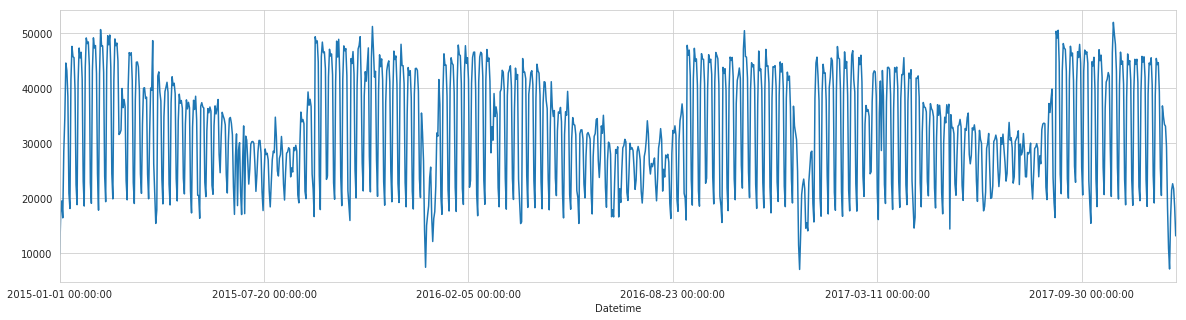

In [66]:
fig,ax = plt.subplots(figsize=(20,5))
obs.set_index('Datetime')[['11']].plot(ax=ax, legend=False)
plt.show()

/opt/conda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


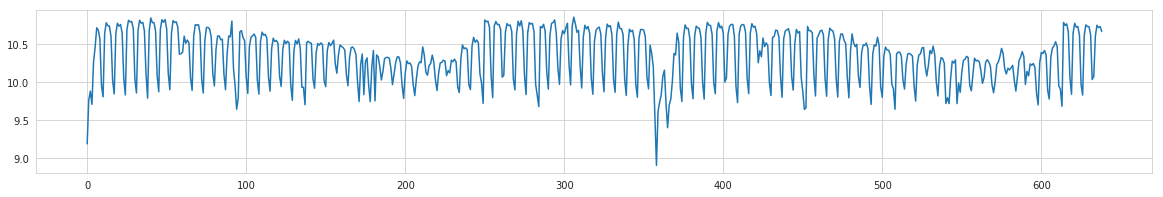

In [67]:
training=np.log(Yendog_train)
training = np.nan_to_num(training)

fig,ax = plt.subplots(figsize=(20,3))
plt.plot(training[:,0])
plt.show()

date_list = utils_date.get_list_common_date(start_train, end_train, obs, [fea])
df_training = pd.DataFrame(data=date_list, columns = ['Datetime'])
for idx,ts in enumerate(time_series):
    df_training[ts] = training[:,idx]
    
training_diff = np.array([df_training[ts].diff(periods=1)[1:] for idx,ts in enumerate(time_series)]).T
training_diff = np.nan_to_num(training_diff)

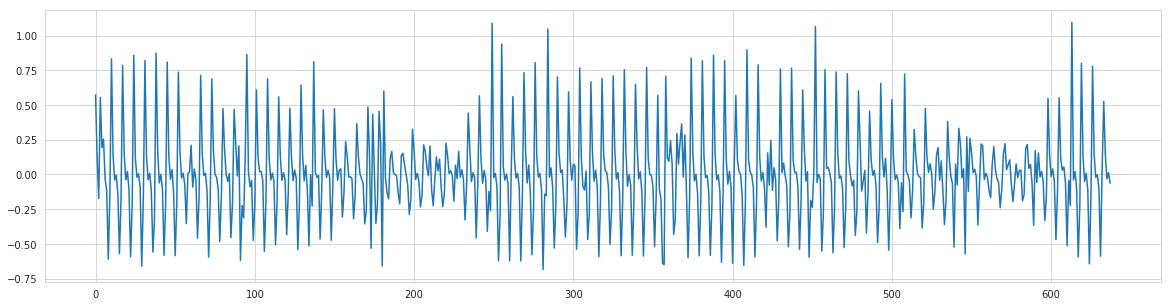

In [68]:
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(training_diff[:,0])
plt.show()


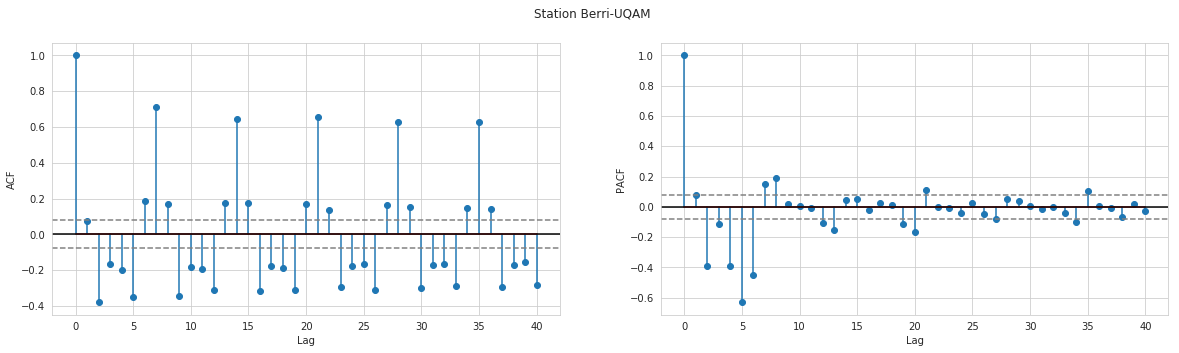

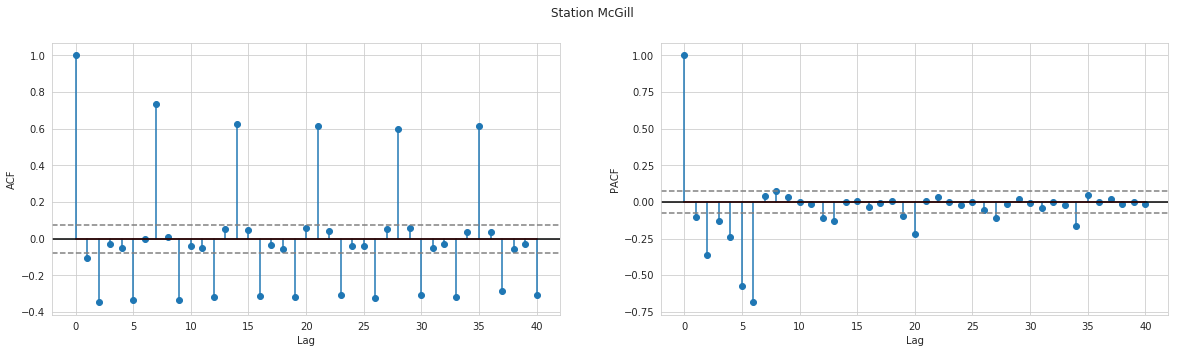

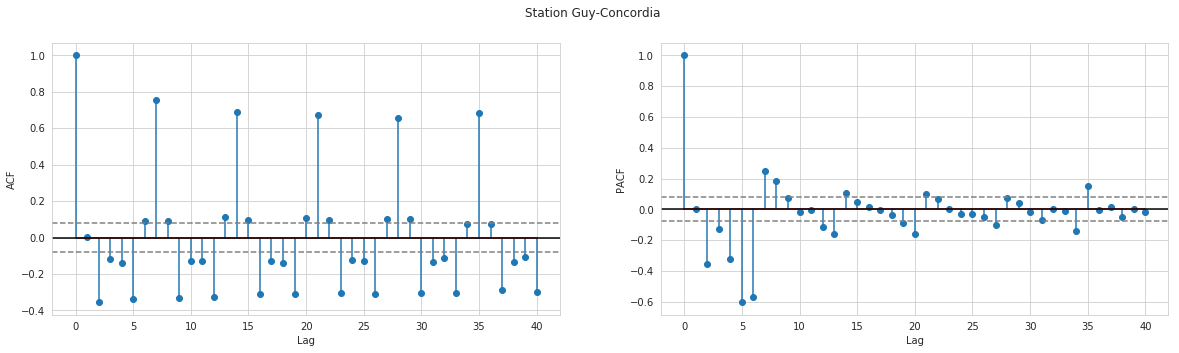

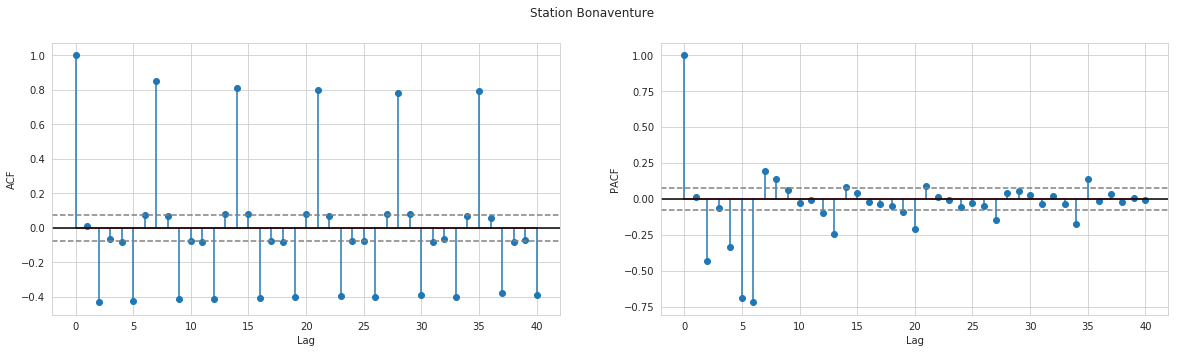

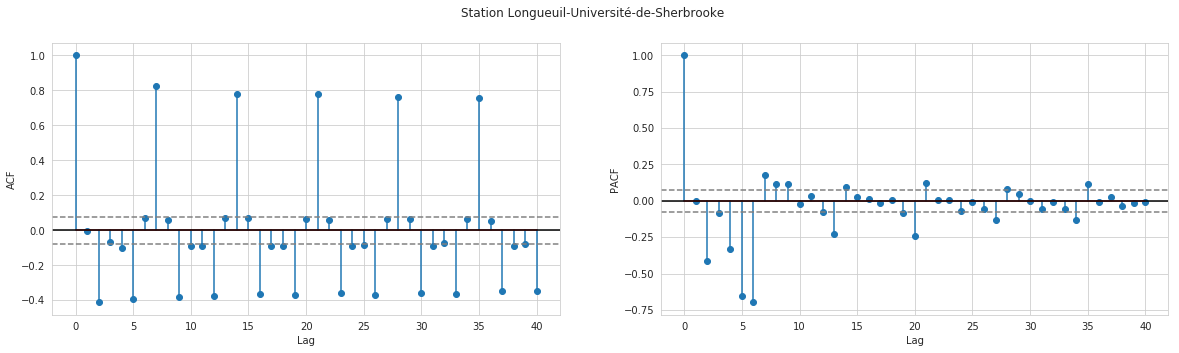

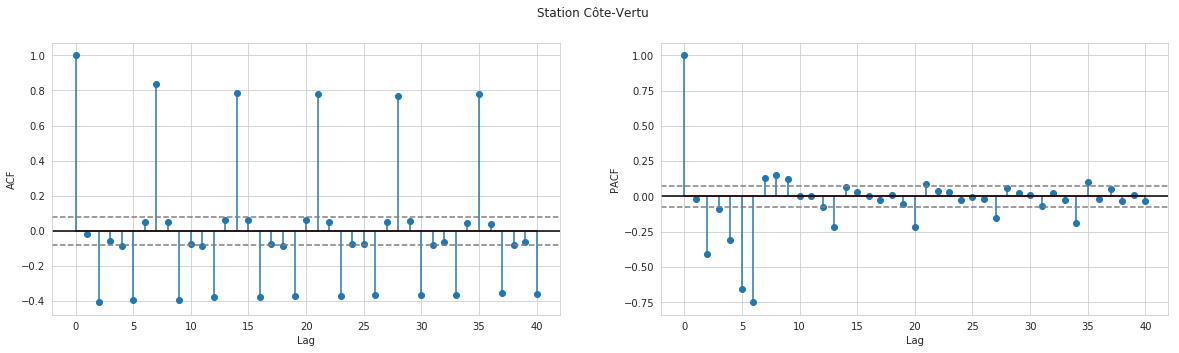

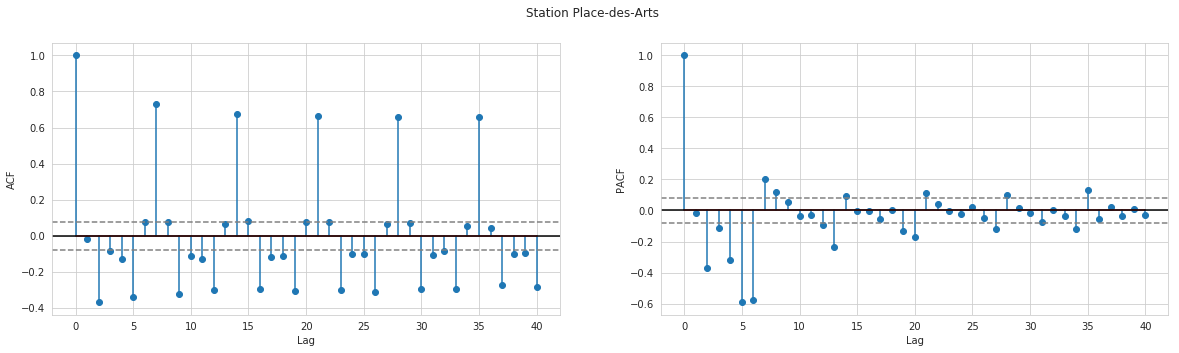

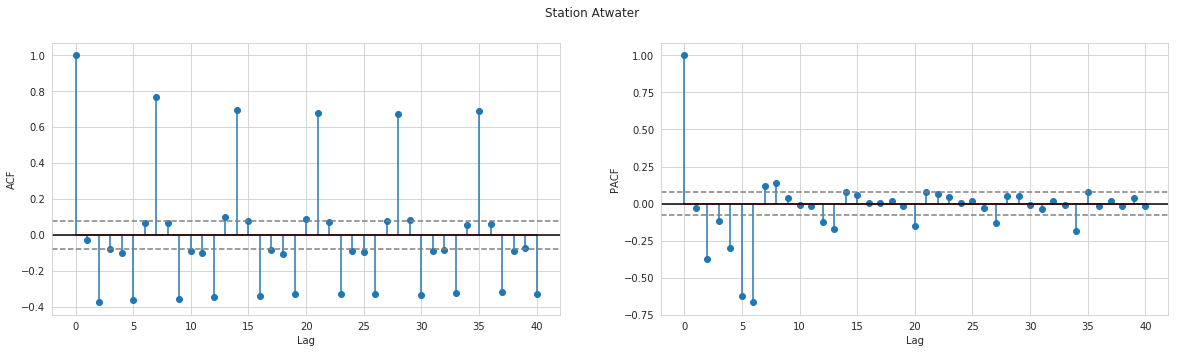

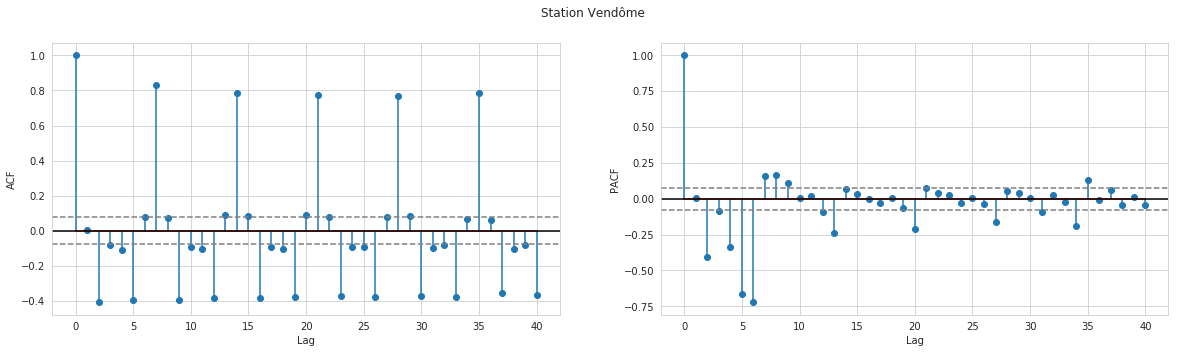

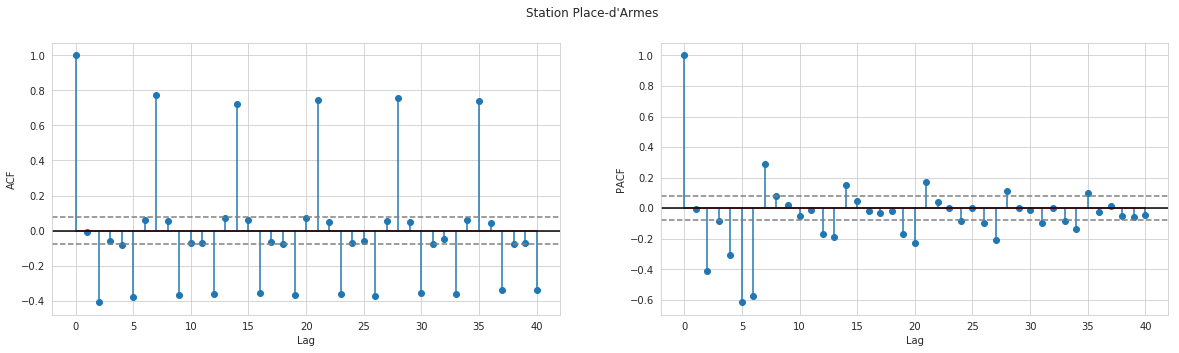

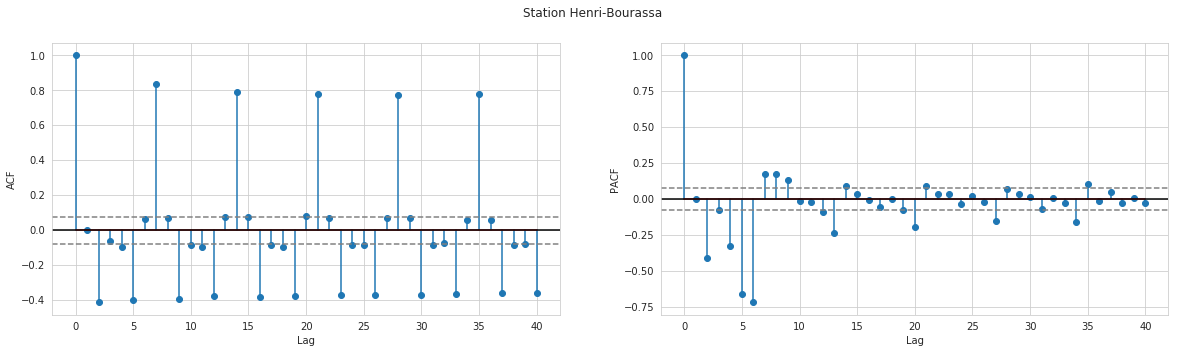

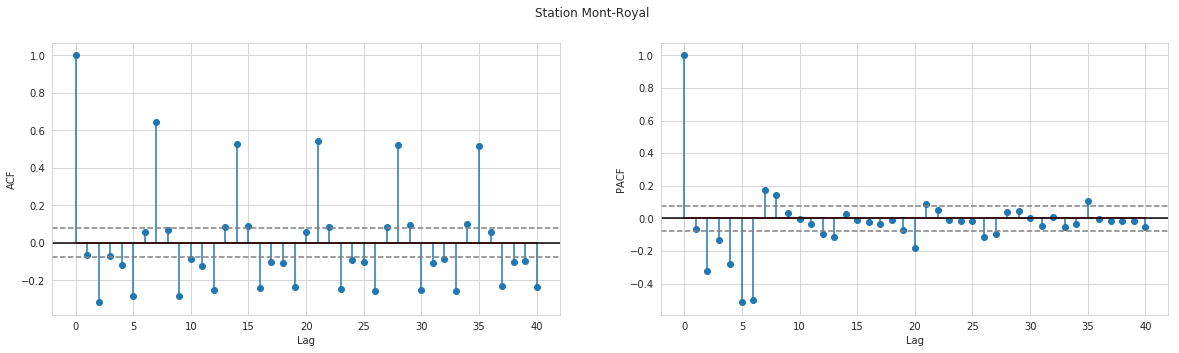

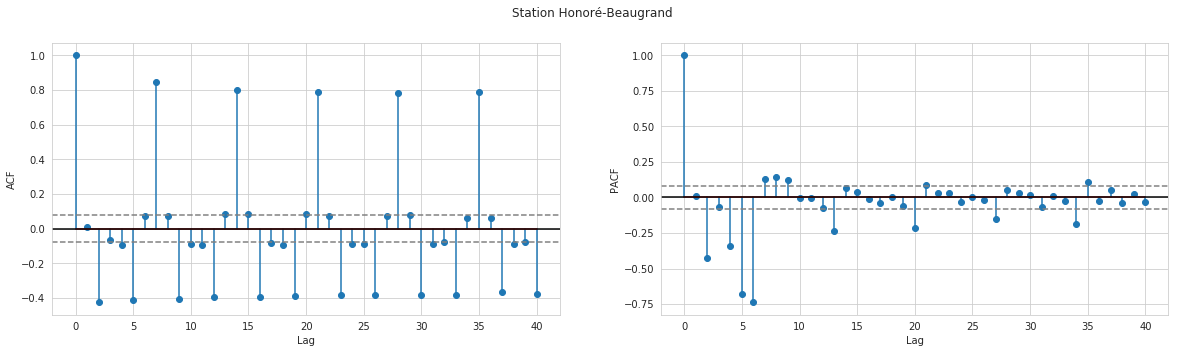

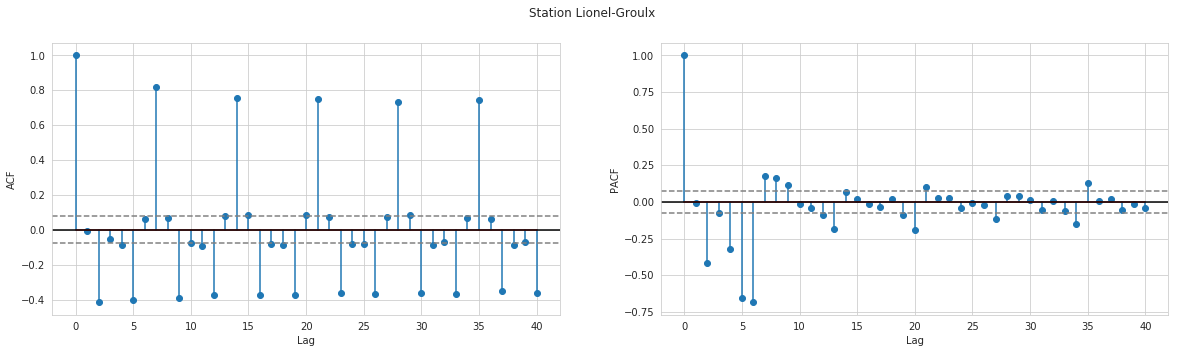

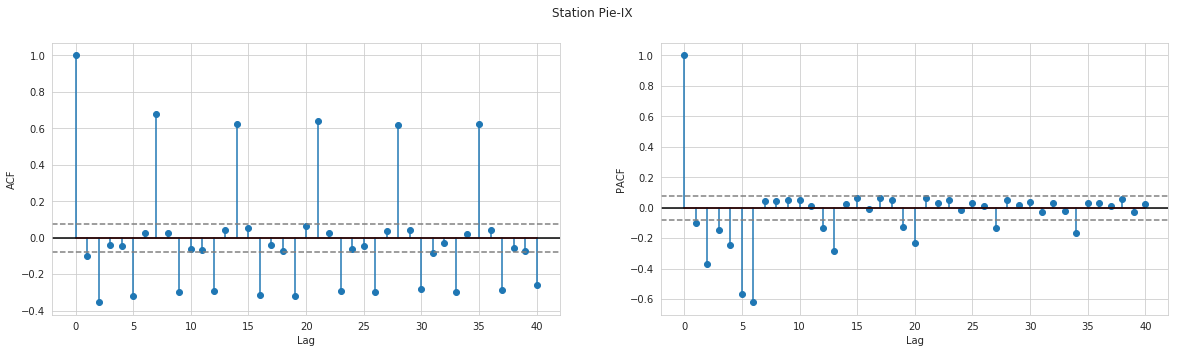

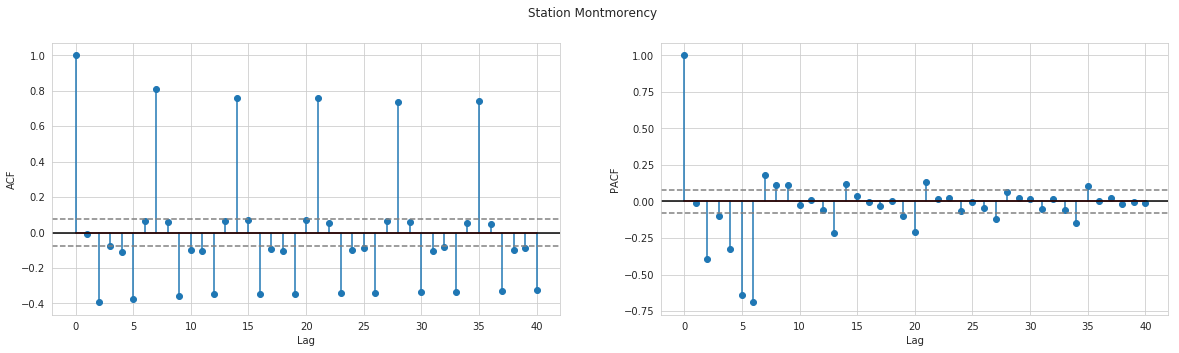

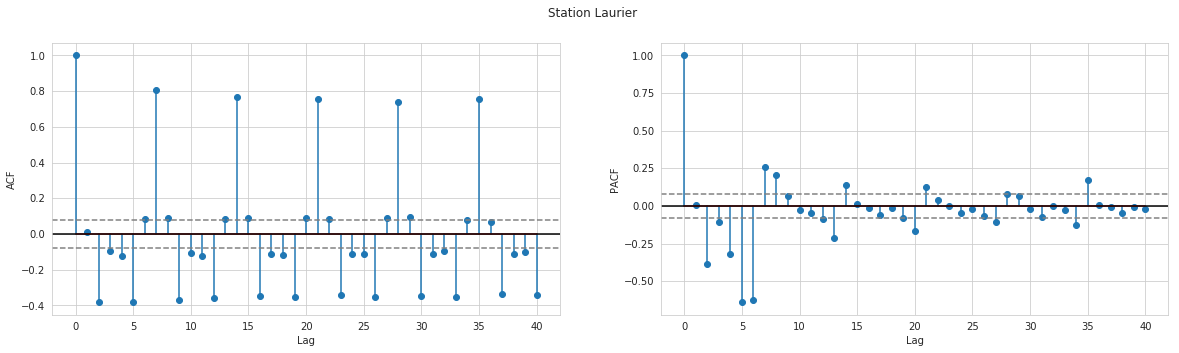

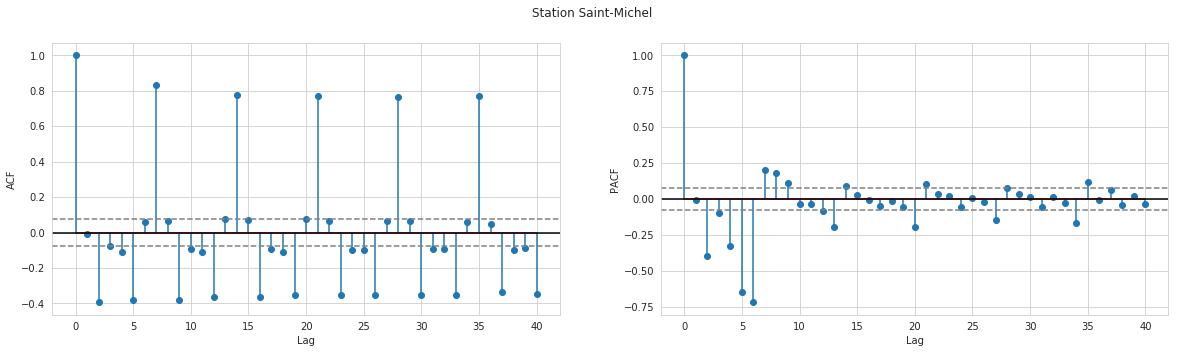

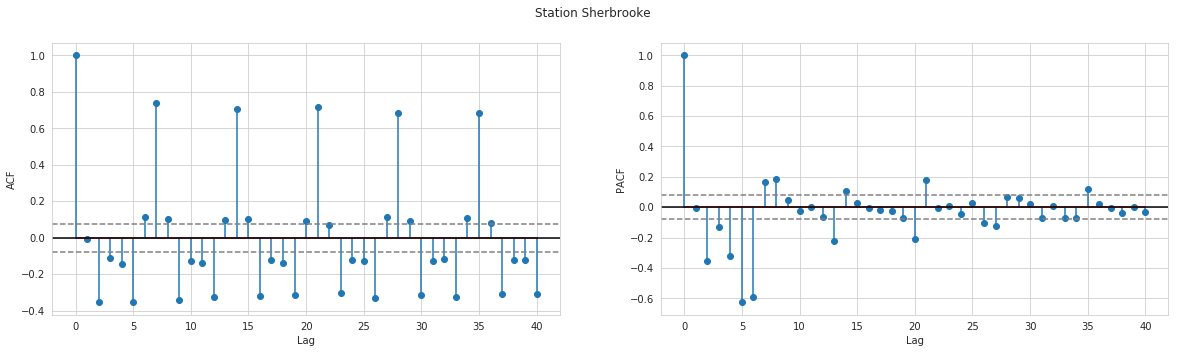

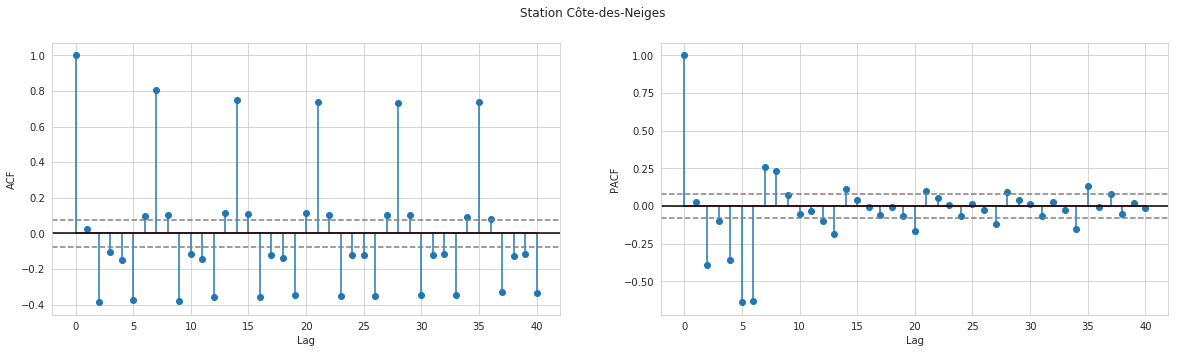

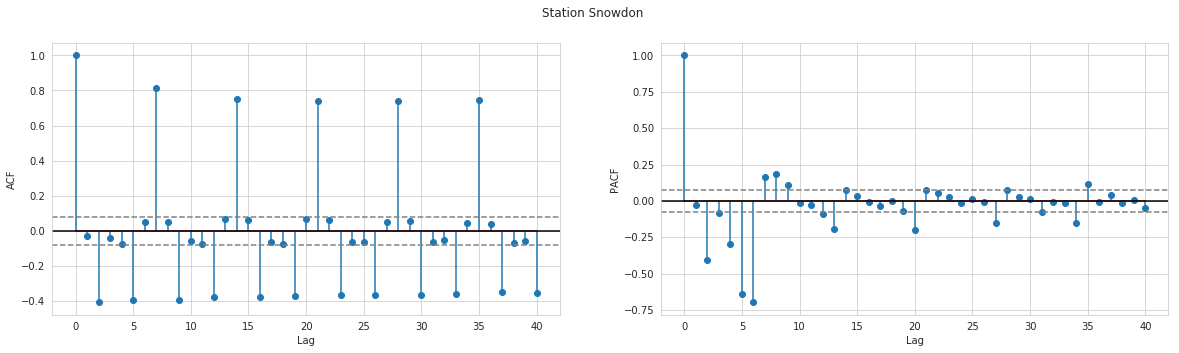

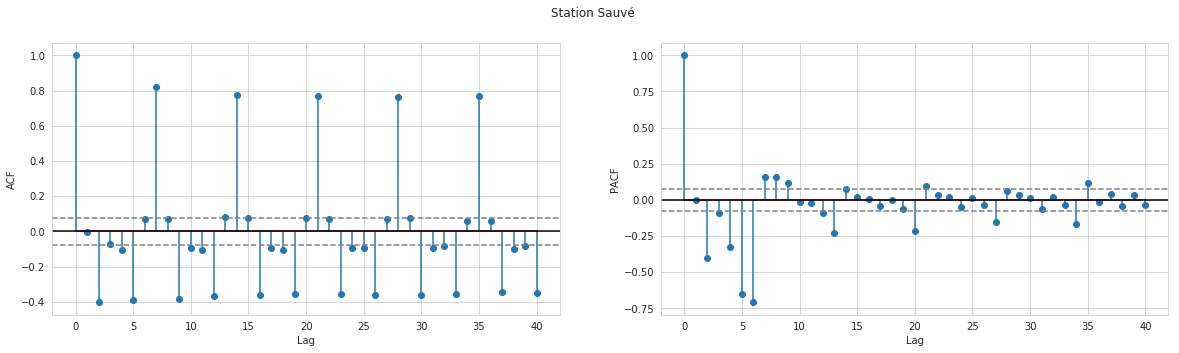

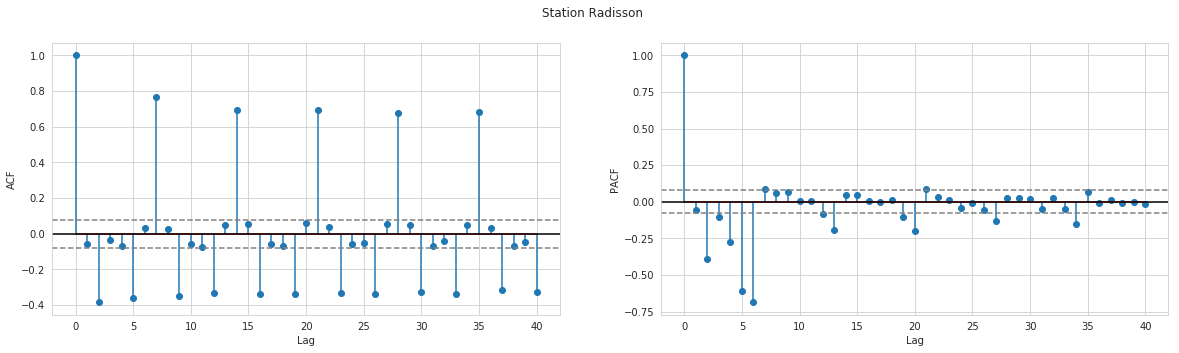

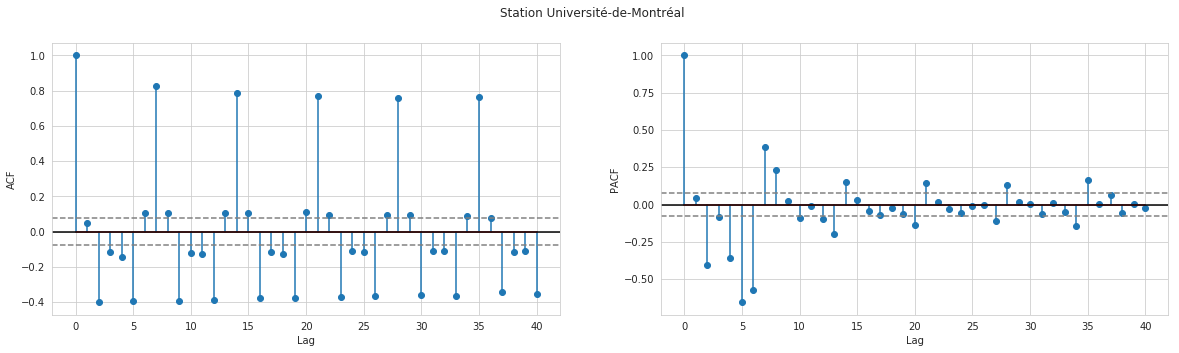

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]
/opt/conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in subtract
  return getattr(obj, method)(*args, **kwds)
/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/data.py:131: RuntimeWarning: overflow encountered in subtract
  ptp_ = self.exog.ptp(axis=0)


MissingDataError: exog contains inf or nans

In [69]:
from statsmodels.tsa.stattools import acf, pacf

for idx, ts in enumerate(time_series):
    lag_acf = acf(training_diff[:,idx], nlags=40)
    lag_pacf = pacf(training_diff[:,idx], nlags=40, method='ols')
    
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    axes[0].stem(lag_acf)
    axes[0].axhline(y=0, linestyle='-', color='black')
    axes[0].axhline(y=-1.96/np.sqrt(len(training)), linestyle='--', color='gray')
    axes[0].axhline(y=1.96/np.sqrt(len(training)), linestyle='--', color='gray')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('ACF')
    
    axes[1].stem(lag_pacf)
    axes[1].axhline(y=0, linestyle='-', color='black')
    axes[1].axhline(y=-1.96/np.sqrt(len(training)), linestyle='--', color='gray')
    axes[1].axhline(y=1.96/np.sqrt(len(training)), linestyle='--', color='gray')
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('PACF')
    
    plt.suptitle('{}'.format(dict_id_name[int(ts)]))
    plt.show()
    

    

In [71]:
def sarima_configs(param_grid):

    configs = [[(i[0],i[1],i[2]), (i[3],i[4],i[5],i[6]), i[7]] for i in itertools.product(*[param_grid['p_params'],
                                                                                            param_grid['d_params'],
                                                                                            param_grid['q_params'],
                                                                                            param_grid['P_params'],
                                                                                            param_grid['D_params'],
                                                                                            param_grid['Q_params'],
                                                                                            param_grid['m_params'],
                                                                                            param_grid['t_params']])]
    return configs



param_grid = {'p_params': [2],
              'd_params': [1],
              'q_params': [2],
              'P_params': [1],
              'D_params': [0],
              'Q_params': [0], 
              'm_params': [7], 
              't_params': ['c']}

# Configs 
configs = sarima_configs(param_grid)  


/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


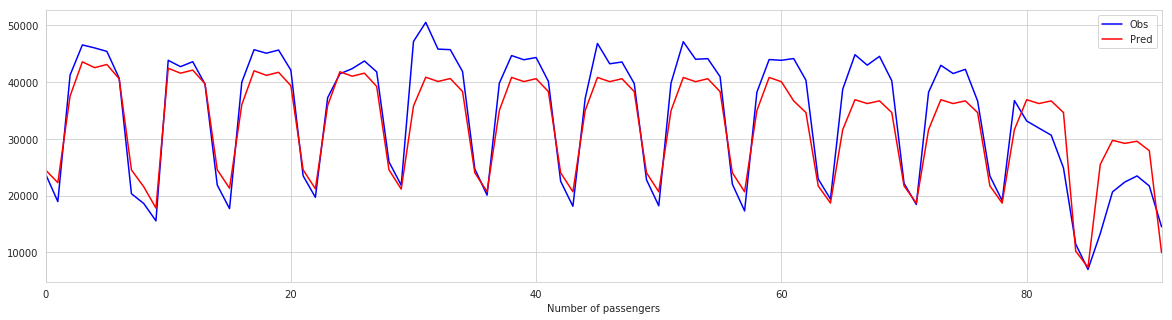

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [88]:
for idx, ts in enumerate(time_series[:3]):
    model = sarimax.SARIMAX(training[:,idx],exog=exog_train, order = configs[0][0], seasonal_order = configs[0][1],
                            enforce_invertibility=False, enforce_stationarity=False )
    model_fit = model.fit(disp=5)
    
    pred = model_fit.forecast(len(exog_val),exog=exog_val)
    pred = np.exp(pred)
    
    #fig,ax = plt.subplots(figsize=(20,5))
    #plt.plot(Yendog[:,idx], c='b', label='Obs')
    #plt.plot(np.arange(len(Yendog_train),len(Yendog_train)+len(pred)),pred, c='r', label='Pred')
    #plt.xlabel('Month')
    #plt.xlabel('Number of passengers')
    #plt.autoscale(enable=True, axis='x', tight=True)
    #plt.axvline(x=len(exog_train), color='black')
    #plt.legend()
    #plt.show()
    
    fig,ax = plt.subplots(figsize=(20,5))
    plt.plot(Yendog_val[:,idx], c='b', label='Obs')
    plt.plot(pred, c='r', label='Pred')
    plt.xlabel('Month')
    plt.xlabel('Number of passengers')
    plt.autoscale(enable=True, axis='x', tight=True)
    #plt.axvline(x=len(exog_train), color='black')
    plt.legend()
    plt.show()                 

# Train - Test

In [152]:
start_train, end_train, end_test = '2015-01-01',  '2017-01-01', '2018-01-01'

date_list = utils_date.get_list_common_date(start_train, end_test, obs, [fea])

Yendog, exog, Yendog_name_list, exog_name_list = create_Xy_basic(start_train, end_test, obs, fea)
index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))

Yendog_train, Yendog_test = Yendog[:index_train], Yendog[index_train:]
exog_train, exog_test = exog[:index_train], exog[index_train:]

training = np.log(Yendog_train)
training = np.nan_to_num(training)
training[(training<0.001)&(training>-0.001)]=0
training[(training<-1*10**30)]=0
training[(training>1*10**30)]=0

In [139]:
def sarima_configs(param_grid):

    configs = [[(i[0],i[1],i[2]), (i[3],i[4],i[5],i[6]), i[7]] for i in itertools.product(*[param_grid['p_params'],
                                                                                            param_grid['d_params'],
                                                                                            param_grid['q_params'],
                                                                                            param_grid['P_params'],
                                                                                            param_grid['D_params'],
                                                                                            param_grid['Q_params'],
                                                                                            param_grid['m_params'],
                                                                                            param_grid['t_params']])]
    return configs



param_grid = {'p_params': [2],
              'd_params': [1],
              'q_params': [2],
              'P_params': [1],
              'D_params': [0],
              'Q_params': [0], 
              'm_params': [7], 
              't_params': ['c']}

# Configs 
configs = sarima_configs(param_grid)  


In [279]:
import warnings
warnings.filterwarnings('ignore')

predictions = []

for idx, ts in enumerate(tqdm(time_series)):

    model = sarimax.SARIMAX(training[:,idx],exog=exog_train, order = configs[0][0], seasonal_order = configs[0][1],
                                enforce_invertibility=False, enforce_stationarity=False, )
    model_fit = model.fit(disp=5)
    
    pred = model_fit.forecast(len(exog_test),exog=exog_test)
    pred = np.exp(pred)
    
    predictions.append(pred)
    
    #fig,ax = plt.subplots(figsize=(20,5))
    #plt.plot(Yendog_test[:,idx], c='b', label='Obs')
    #plt.plot(pred, c='r', label='Pred')
    #plt.xlabel('Month')
    #plt.xlabel('Number of passengers')
    #plt.autoscale(enable=True, axis='x', tight=True)
    #plt.legend()
    #plt.show()                 





  0%|          | 0/68 [00:00<?, ?it/s]




ValueError: endog and exog matrices are different sizes

In [142]:
predictions = np.array(predictions)

In [147]:
df_res = obs.copy().set_index('Datetime').loc[date_list].loc[end_train:end_test]
for idx,ts in enumerate(time_series):
    df_res[ts] = predictions[idx]
df_res = df_res.reset_index()

In [151]:
utils.rmse(obs.copy().set_index('Datetime').loc[date_list].loc[end_train:end_test].values.flatten(),df_res.set_index('Datetime').values.flatten())

2137.3980944932437

Score catastrophique

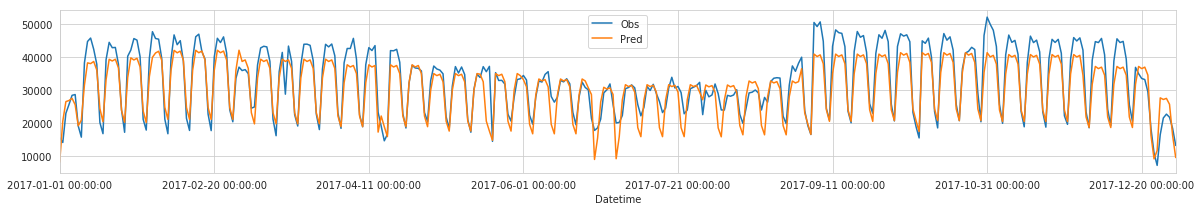

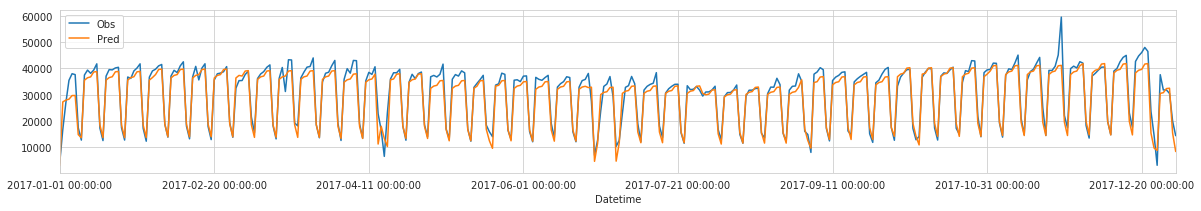

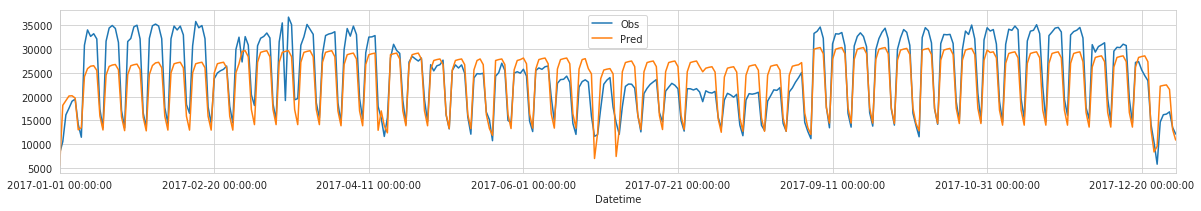

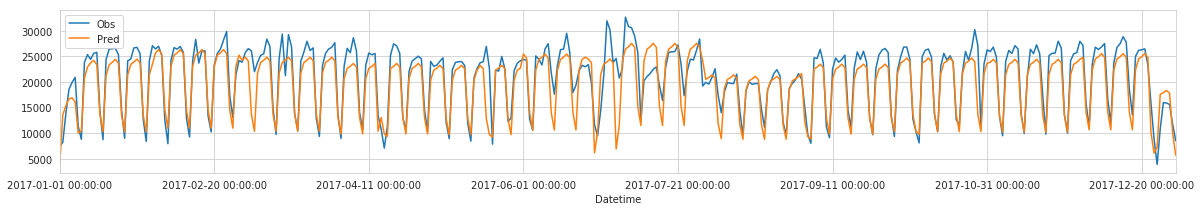

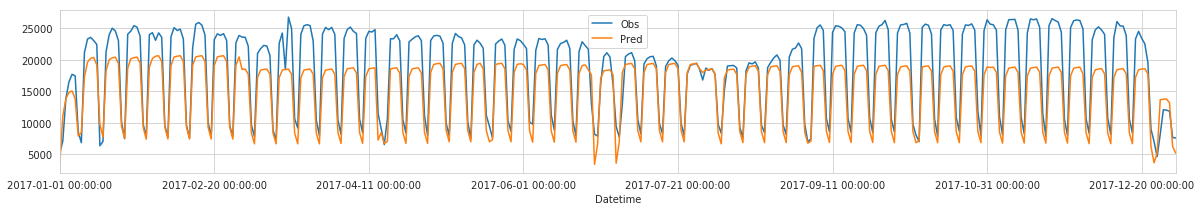

In [153]:
for ts in time_series[:10]:
    fig,ax = plt.subplots(figsize=(20,3))
    obs.copy().set_index('Datetime').loc[date_list].loc[end_train:end_test][ts].plot(ax=ax)
    df_res.set_index('Datetime')[ts].plot(ax=ax)
    plt.legend(['Obs','Pred'])
    plt.show()

# Trend et prévision de la trend

FREQ = 1


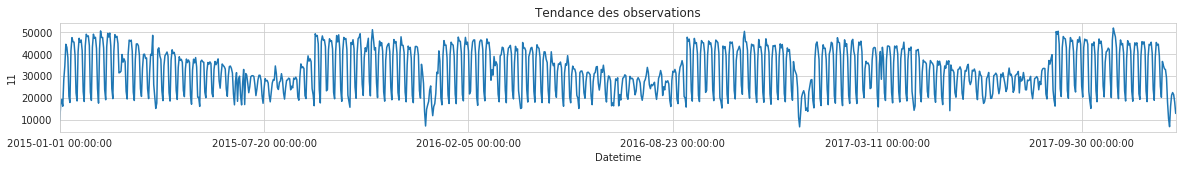

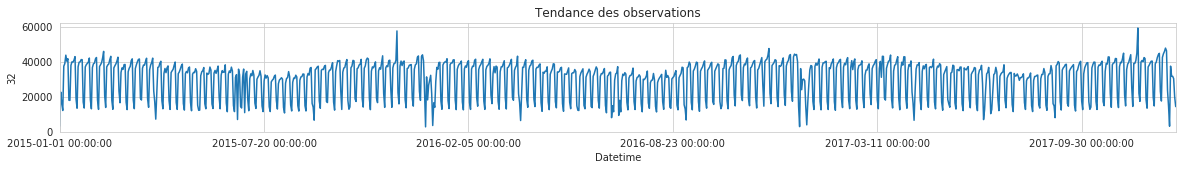

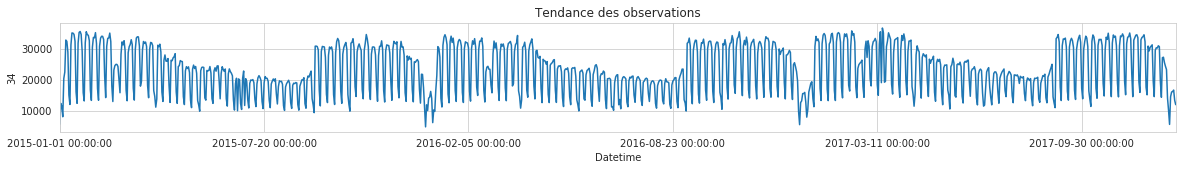

FREQ = 10


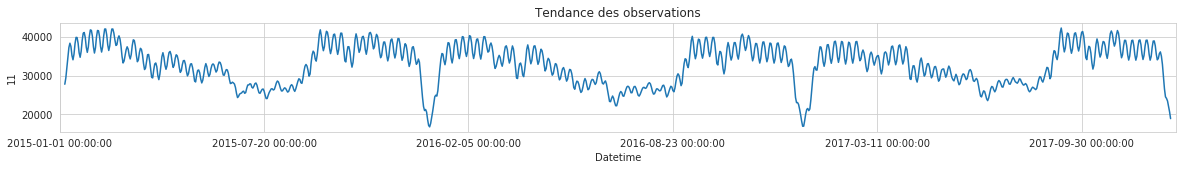

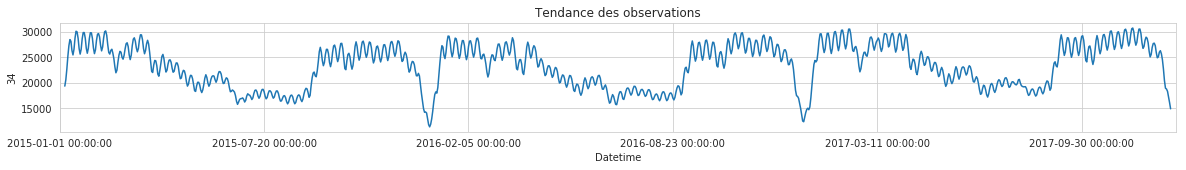

FREQ = 30


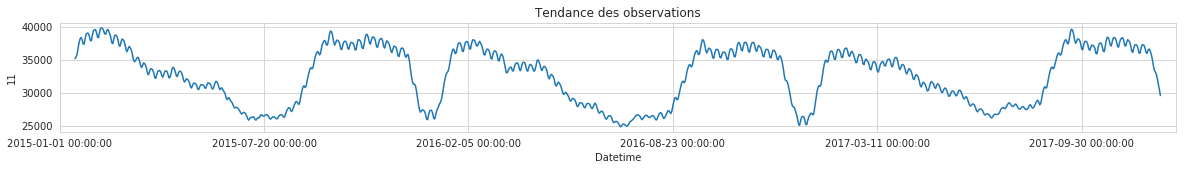

FREQ = 60


FREQ = 90


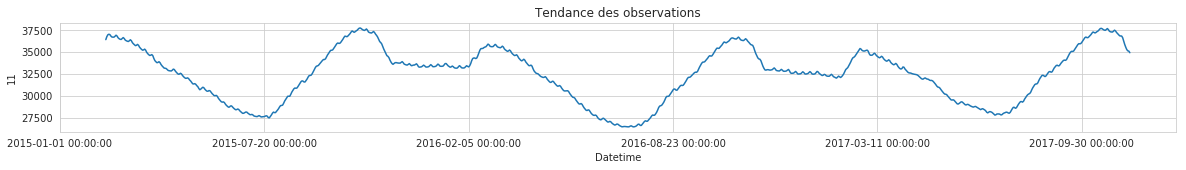

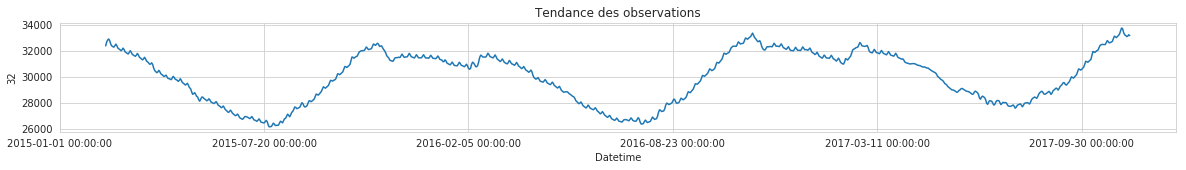

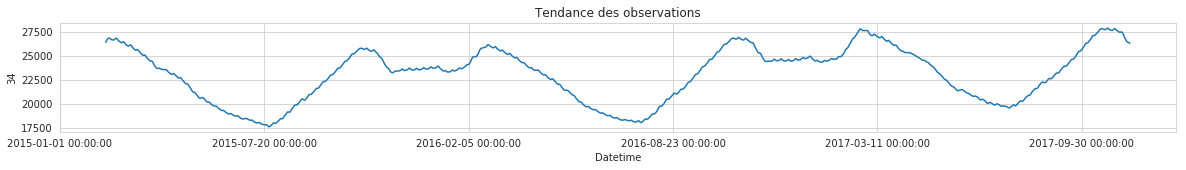

FREQ = 120


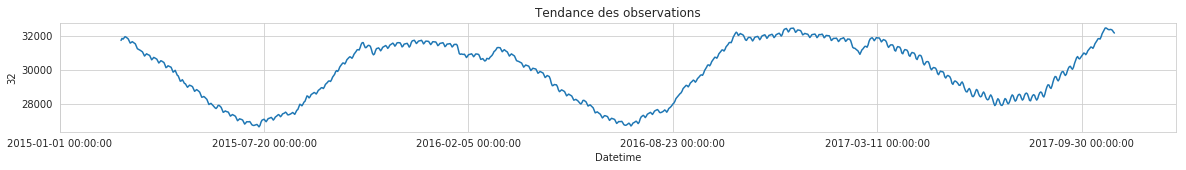

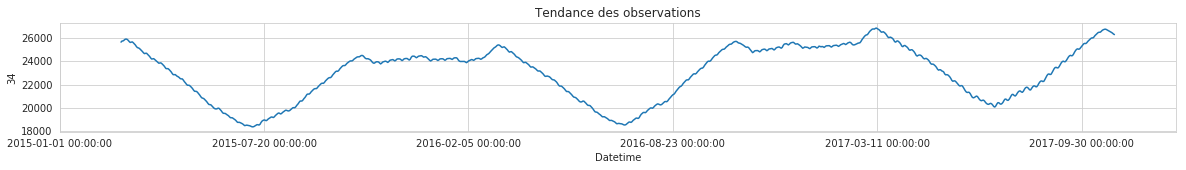

In [157]:
nts = 3

for freq in [1,10,30,60,90,120]:
    print('FREQ = {}'.format(freq))

    for idx,ts in enumerate(time_series[:nts]):
        result_obs = seasonal_decompose(obs.set_index('Datetime').loc[date_list][ts], model='additive', freq=freq)
        fig,ax = plt.subplots(figsize=(20,2))
        result_obs.trend.plot(ax=ax, legend = False)
        plt.ylabel(ts)
        plt.title('Tendance des observations')
        plt.show()

In [450]:
param_grid = {'p_params': [0],
              'd_params': [0],
              'q_params': [0],
              'P_params': [1],
              'D_params': [0],
              'Q_params': [0], 
              'm_params': [365], 
              't_params': ['c']}

# Configs 
configs = sarima_configs(param_grid)  

In [451]:
start_train = '2015-01-01'
end_train = '2017-01-01'
start_test = '2017-01-01'
end_test = '2018-01-01'

date_list_train = utils_date.get_list_common_date(start_train, end_train, obs, [fea])
date_list_test = utils_date.get_list_common_date(start_train, end_test, obs, [fea])

freq = 30
nts=2

for idx,ts in enumerate(time_series[:nts]):
    result_decompose_train = seasonal_decompose(obs.set_index('Datetime').loc[date_list_train][ts],
                                    model='additive', freq=freq)
    result_decompose_all = seasonal_decompose(obs.set_index('Datetime').loc[date_list_test][ts],
                                    model='additive', freq=freq)
    

       

In [443]:
len(Yendog_train)

701

In [ ]:
df_train = result_decompose_train.trend.to_frame().dropna().reset_index()
df_all = result_decompose_all.trend.to_frame().dropna().reset_index()

start_train  = df_train.set_index('Datetime').index.values[0]
end_train = df_train.set_index('Datetime').index.values[-1]
end_test = df_all.set_index('Datetime').index.values[-1]


date_list = utils_date.get_list_common_date(start_train, end_test, df_all, [fea])

Yendog, exog, Yendog_name_list, exog_name_list = create_Xy_basic(start_train, end_test, df_all, fea)
index_train = len(utils_date.get_list_common_date(start_train, end_train, df_all, [fea]))

Yendog_train, Yendog_test = Yendog[:index_train,0], Yendog[index_train:,0]
exog_train, exog_test = exog[:index_train], exog[index_train:]


model = sarimax.SARIMAX(Yendog_train, exog=exog_train, order = configs[0][0], seasonal_order = configs[0][1],
                                enforce_invertibility=False, enforce_stationarity=False,  simple_differencing = True, )
#model = arima_model.ARIMA(Yendog_train,exog=exog_train, order = configs[0][0], dates = utils_date.get_list_common_date(start_train, end_train, df_all, [fea]))

model_fit = model.fit(disp=1, maxiter=50)

In [462]:
pred = model_fit.forecast(len(exog_test),exog=exog_test)
#pred = model_fit.forecast(len(exog_test))
#pred = model_fit.forecast(len(exog_test),exog_test)[0]

In [463]:
utils.rmse(df_plot.dropna()[ts].values, df_plot.dropna()[ts+'_'].values)

1264.6033524612287

freq = 30  

SARIMAX (1)  
param_grid = {'p_params': [1],
              'd_params': [0],
              'q_params': [0],
              'P_params': [1],
              'D_params': [0],
              'Q_params': [0], 
              'm_params': [365], 
              't_params': ['c']}          
error = 1184.81566863

ARIMA  
p_params = 20  
error 1638.9497238088945

SARIMAX (2)  
param_grid = {'p_params': [0],
              'd_params': [0],
              'q_params': [0],
              'P_params': [1],
              'D_params': [0],
              'Q_params': [0], 
              'm_params': [365], 
              't_params': ['c']}          
error = 1190.0930137343478



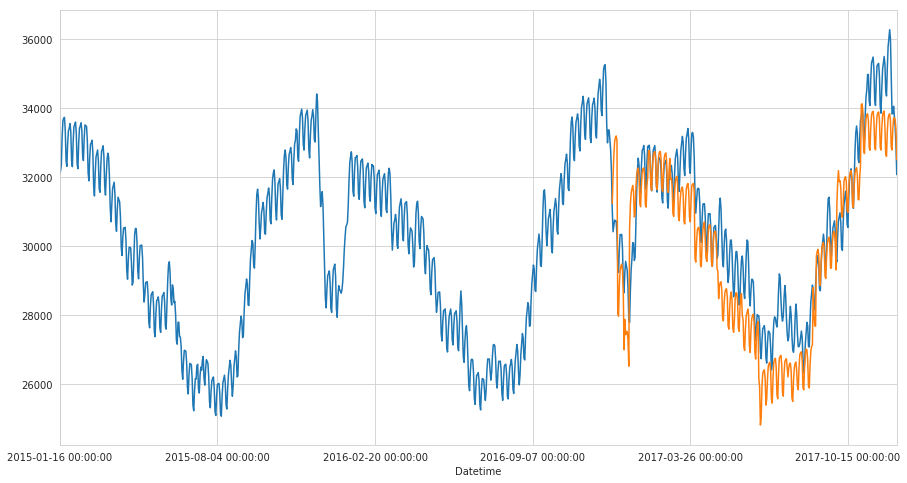

In [357]:
# SARIMAX (1)
df_obs = pd.DataFrame(data=date_list, columns=['Datetime'])
df_pred = pd.DataFrame(data = utils_date.get_list_common_date(end_train, end_test, df_all, [fea])[1:], columns=['Datetime'])
df_obs[ts] = Yendog
df_pred[ts+'_'] = pred

df_plot = df_obs.set_index('Datetime').join(df_pred.set_index('Datetime'))
                       
fig,ax = plt.subplots(figsize=(15,8))
df_plot[ts].plot(ax=ax)
df_plot[ts+'_'].plot(ax=ax)


plt.show()

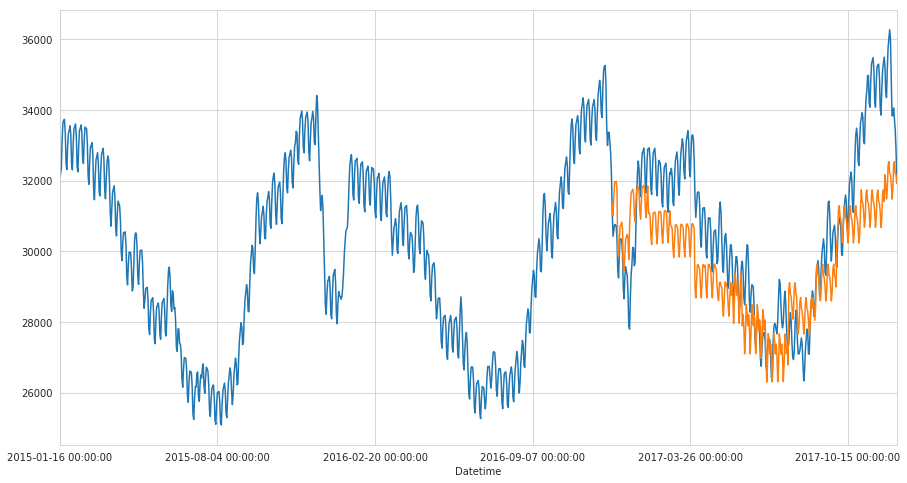

In [446]:
# ARIMA
df_obs = pd.DataFrame(data=date_list, columns=['Datetime'])
df_pred = pd.DataFrame(data = utils_date.get_list_common_date(end_train, end_test, df_all, [fea])[1:], columns=['Datetime'])
df_obs[ts] = Yendog
df_pred[ts+'_'] = pred

df_plot = df_obs.set_index('Datetime').join(df_pred.set_index('Datetime'))
                       
fig,ax = plt.subplots(figsize=(15,8))
df_plot[ts].plot(ax=ax)
df_plot[ts+'_'].plot(ax=ax)


plt.show()

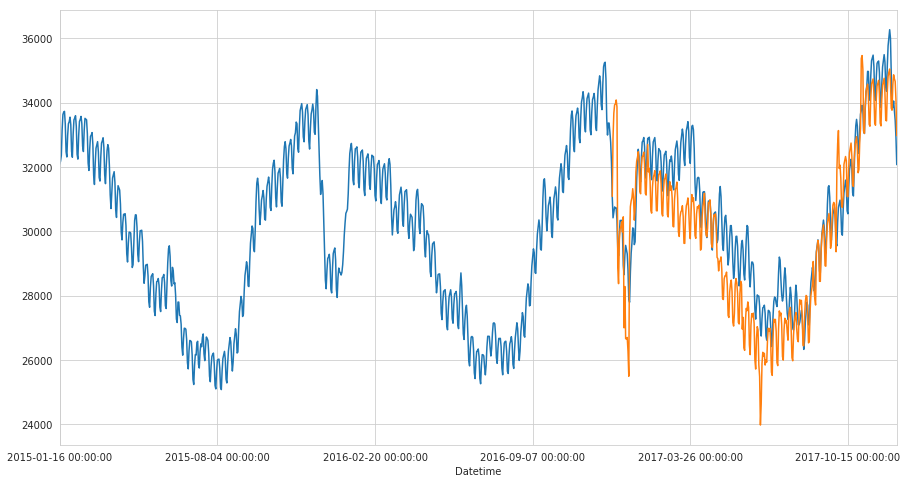

In [464]:
# SARIMAX (2)
df_obs = pd.DataFrame(data=date_list, columns=['Datetime'])
df_pred = pd.DataFrame(data = utils_date.get_list_common_date(end_train, end_test, df_all, [fea])[1:], columns=['Datetime'])
df_obs[ts] = Yendog
df_pred[ts+'_'] = pred

df_plot = df_obs.set_index('Datetime').join(df_pred.set_index('Datetime'))
                       
fig,ax = plt.subplots(figsize=(15,8))
df_plot[ts].plot(ax=ax)
df_plot[ts+'_'].plot(ax=ax)


plt.show()